In [1]:
from __future__ import print_function

import scipy.io as sio  
import matplotlib.pyplot as plt  
import numpy as np 
import tensorflow as tf
import os, sys
import math
import seaborn
from data_buffer import Data_buffer
%matplotlib inline

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
window_size = 8
data_buffer = Data_buffer(window_size=window_size)
csi1_filename = '/Users/wangweiguo/Desktop/zigfi/python_data/wifi10/dis15pow23.mat'
csi0_filename = '/Users/wangweiguo/Desktop/zigfi/python_data/wifi10/dis1air2.mat'
data_buffer.load_csi_from_file(csi1_filename, csi0_filename)

len of csi 1: 37233  len of csi 0: 36204


Epoch: 0001 cost= 49.095965130
test  Accuracy: 0.730055
train  Accuracy: 0.6742
Epoch: 0002 cost= 9.398109930
Epoch: 0003 cost= 5.260684211
Epoch: 0004 cost= 3.669836573
Epoch: 0005 cost= 2.942551659
Epoch: 0006 cost= 2.411616722
Epoch: 0007 cost= 2.056823130
Epoch: 0008 cost= 1.733831188
Epoch: 0009 cost= 1.518672422
Epoch: 0010 cost= 1.424180157
Epoch: 0011 cost= 1.279405118
test  Accuracy: 0.899454
train  Accuracy: 0.879
Epoch: 0012 cost= 1.151692718
Epoch: 0013 cost= 1.033336243
Epoch: 0014 cost= 0.944934906
Epoch: 0015 cost= 0.872401594
Epoch: 0016 cost= 0.790743941
Epoch: 0017 cost= 0.713629167
Epoch: 0018 cost= 0.674288374
Epoch: 0019 cost= 0.638247419
Epoch: 0020 cost= 0.566647197
Epoch: 0021 cost= 0.557876552
test  Accuracy: 0.944262
train  Accuracy: 0.9248
Epoch: 0022 cost= 0.541989679
Epoch: 0023 cost= 0.479453908
Epoch: 0024 cost= 0.478498713
Epoch: 0025 cost= 0.433897971
Epoch: 0026 cost= 0.409236842
Epoch: 0027 cost= 0.401947708
Epoch: 0028 cost= 0.373489356
Epoch: 0029 c

Epoch: 0236 cost= 0.024175863
Epoch: 0237 cost= 0.022069671
Epoch: 0238 cost= 0.020131623
Epoch: 0239 cost= 0.022080873
Epoch: 0240 cost= 0.023958666
Epoch: 0241 cost= 0.023230370
test  Accuracy: 0.986885
train  Accuracy: 0.989
Epoch: 0242 cost= 0.025163232
Epoch: 0243 cost= 0.019644607
Epoch: 0244 cost= 0.021490057
Epoch: 0245 cost= 0.019635959
Epoch: 0246 cost= 0.021114505
Epoch: 0247 cost= 0.020744846
Epoch: 0248 cost= 0.022062035
Epoch: 0249 cost= 0.018822665
Epoch: 0250 cost= 0.023828126
Epoch: 0251 cost= 0.022884631
test  Accuracy: 0.980328
train  Accuracy: 0.992


KeyboardInterrupt: 

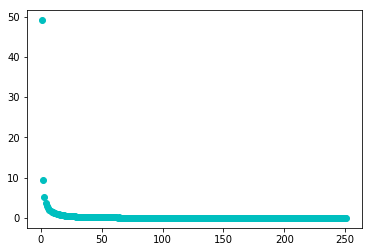

In [9]:
# 设置模型参数
learning_rate = 0.001
training_epochs = 500
batch_size = 100
display_step = 1
n_sample = int( len(data_buffer.csi_bit1_train)/8 + len(data_buffer.csi_bit0_train)/8 )

n_input = window_size
n_hidden_1 = 32
n_hidden_2 = 64
n_hidden_3 = 32
n_class = 2

x = tf.placeholder('float', [None, n_input])
y = tf.placeholder('float', [None, n_class])


def multiplayer_perceptron(x, weight, bias):
    layer1 = tf.add(tf.matmul(x, weight['h1']), bias['h1'])
    layer1 = tf.nn.relu(layer1)
    layer2 = tf.add(tf.matmul(layer1, weight['h2']), bias['h2'])
    layer2 = tf.nn.relu(layer2)
    layer3 = tf.add(tf.matmul(layer2, weight['h3']), bias['h3'])
    layer3 = tf.nn.relu(layer3)
    out_layer = tf.add(tf.matmul(layer3, weight['out']), bias['out'])
    out_layer = tf.nn.dropout(out_layer, keep_prob=0.9)
    return out_layer


weight = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])), 
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])), 
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_class]))
}
bias = {
    'h1': tf.Variable(tf.random_normal([n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_2])), 
    'h3': tf.Variable(tf.random_normal([n_hidden_3])), 
    'out': tf.Variable(tf.random_normal([n_class]))
}

# 建立模型
pred = multiplayer_perceptron(x, weight, bias)

# 定义损失函数
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

# 优化
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# 初始化所有变量
init = tf.initialize_all_variables()

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

# 训练模型
test_step = 100
X_test, y_test = data_buffer.get_test_set()
X_train, y_train = data_buffer.get_train_set()
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(n_sample / batch_size)

        for i in range(total_batch):
            batch_X, batch_y = data_buffer.next_batch()
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_X, 
                                                          y: batch_y})
            avg_cost += c / total_batch

        plt.plot(epoch+1, avg_cost, 'co')

        if epoch % display_step == 0:
            print('Epoch:', '%04d' % (epoch+1), 'cost=', '{:.9f}'.format(avg_cost))
        if epoch % 10 == 0:
            acc = accuracy.eval({x: X_test, y: y_test})
            print('test  Accuracy:', acc)
            acc = accuracy.eval({x: X_train, y: y_train})
            print('train  Accuracy:', acc)
    print('Opitimization Finished!')
    # Test
    acc = accuracy.eval({x: X_test, y: y_test})
    print('test  Accuracy:', acc)
    #acc = accuracy.eval({x: X_train, y: y_train})
    #print('train Accuracy:', acc)

    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('lr=%f, te=%d, bs=%d, acc=%f' % (learning_rate, training_epochs, batch_size, acc))
    plt.tight_layout()
    plt.show()